This project aims to detect graph isomomprhism from a given graph. We first generate a bunch of isomorphic graphs and non isomorphic graphs as our data. We train our neural network using these data, and then test and state the accuracy.

In [2]:
import tensorflow as tf
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import isomorphism
import random as rnd

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Input, Conv2D, Flatten
import keras.layers.merge as merge
from keras.layers.merge import Concatenate
from keras.utils import np_utils
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [3]:
#generate an automorphism of a graph based in edges forms
def permute_graph(g):
    nodes = list(g.nodes())
    rnd.shuffle(nodes)
    edges = []
    for i,j in list(g.edges()):
        edges += [(nodes[i],nodes[j])]
    return edges

In [17]:
# function to return a matrix from a list of edges
def edges_to_matrix(edges, n):
    matrix = [[0 for i in range(n)] for j in range(n)]
    for i,j in edges:
        matrix[i][j] = 1
    return matrix

In [18]:
#generate a random graphs
n = 16
e = [120,110,100,90,80,70,60,50,40,30,20,10]
graphs = len(e)
g = [nx.dense_gnm_random_graph(n,e[i]) for i in range(graphs)]

edges_g = [permute_graph(g[i]) for i in range(graphs)]

In [19]:
#generate isomorphic data first
size = 3000
x_iso= []
for j in range(graphs):
    x = []
    for i in range(size):
        edges = permute_graph(g[j])
        x += [[np.array(edges_to_matrix(edges,n)),1]]
    x_iso += [x]

In [20]:
#generate non-isomorphic data. Simple idea: take one edge from g and call it h, and generate isomorphic graphs 
#to h. Surely, g and h are not isomorphic.
x_non_iso = []
for j in range(graphs):
    xx = []
    for i in range(size):
        t = rnd.randint(1,len(edges_g[j])) # no of edges less
        rand_edges = set([rnd.randint(0,len(edges_g[j])) for k in range(t)]) # list of removed edges indices
        edges_h = [edges_g[j][k] for k in range(len(edges_g[j])) if k not in rand_edges]
        h = nx.Graph()
        h.add_nodes_from(range(n))
        h.add_edges_from(edges_h) # extra shuffle to perumute the graph (isomorphic to non-isomorphic!)
        edges = permute_graph(h)
        xx += [[np.array(edges_to_matrix(edges,n)),0]]
    x_non_iso += [xx]

In [21]:
#shuffle the data to mix isomorphic and non-isomorphic graphs
x_data_all = [x_iso[j] + x_non_iso[j] for j in range(graphs)]
[rnd.shuffle(x_data_all[j]) for j in range(graphs)]
[print(x_data_all[j][0]) for j in range(graphs)]

[array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1],
       [1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
       [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
       [1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1],
       [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 0]
[array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 1

[None, None, None, None, None, None, None, None, None, None, None, None]

In [22]:
#data extraction
size_train = int((size *4)/3)
x_train_all,y_train_all = [],[]
for j in range(graphs):
    x_train,y_train = [],[]
    for i in range(size_train):
        x_train += [x_data_all[j][i][0]]
        y_train += [x_data_all[j][i][1]]
    x_train,y_train = np.array(x_train),np.array(y_train)
    x_train_all += [x_train]
    y_train_all += [y_train]

x_test_all,y_test_all = [],[]
for j in range(graphs):
    x_test, y_test = [],[]
    for i in range(size_train,size*2):
        x_test += [x_data_all[j][i][0]]  
        y_test += [x_data_all[j][i][1]]
    x_test,y_test = np.array(x_test),np.array(y_test)
    x_test_all += [x_test]
    y_test_all += [y_test]
print("Train size:",size_train)
print("Test  size:",len(y_test_all[0]))

Train size: 4000
Test  size: 2000


In [23]:
len(x_test_all),len(y_test_all),len(x_train_all),len(y_train_all)

(12, 12, 12, 12)

In [24]:
models = [tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8, activation=tf.nn.softmax)
])]*graphs
[models[i].compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) for i in range(graphs)]

[models[i].fit(x_train_all[i], y_train_all[i], epochs=6) for i in range(graphs)]
liss_accu = [models[i].evaluate(x_test_all[i], y_test_all[i]) for i in range(graphs)]

Epoch 1/6
4000/4000 [==============================] - 1s 185us/step - loss: 0.5281 - acc: 0.7662
Epoch 2/6
4000/4000 [==============================] - 0s 85us/step - loss: 0.2964 - acc: 0.8962
Epoch 3/6
4000/4000 [==============================] - 0s 86us/step - loss: 0.2097 - acc: 0.9305
Epoch 4/6
4000/4000 [==============================] - 0s 83us/step - loss: 0.1656 - acc: 0.9485
Epoch 5/6
4000/4000 [==============================] - 0s 87us/step - loss: 0.1321 - acc: 0.9590
Epoch 6/6
4000/4000 [==============================] - 0s 83us/step - loss: 0.1228 - acc: 0.9583
Epoch 1/6
4000/4000 [==============================] - 0s 86us/step - loss: 0.2399 - acc: 0.9055
Epoch 2/6
4000/4000 [==============================] - 0s 85us/step - loss: 0.1574 - acc: 0.9435
Epoch 3/6
4000/4000 [==============================] - 0s 88us/step - loss: 0.1086 - acc: 0.9685
Epoch 4/6
4000/4000 [==============================] - 0s 101us/step - loss: 0.0746 - acc: 0.9818
Epoch 5/6
4000/4000 [=======

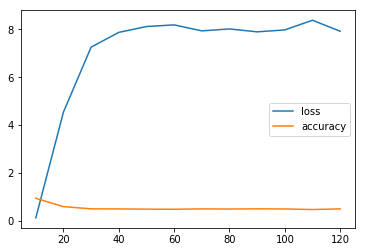

In [25]:
import pandas as pd 
d = pd.DataFrame(np.array(liss_accu), index = e,columns = ["loss","accuracy"])
d.plot()

In [26]:
# The following function is used to serve up both train and validation data.
def data_generator(X, Y, batchsize):
    nb_classes = 2
    N = X.shape[0]
    while True:
        indices1 = np.random.randint(low=0, high=N, size=(batchsize,))
        indices2 = np.random.randint(low=0, high=N, size=(batchsize,))
        
        X1 = X[indices1,...].astype('float32') / 255.0
        X2 = X[indices2,...].astype('float32') / 255.0
        Y1 = Y[indices1]
        Y2 = Y[indices2]
        T  = (Y1 + Y2) # Sum of values.
        
        X1 = np.expand_dims(X1, axis=1) # For conv with theano, shape=(batchsize, channels, row, col).
        X2 = np.expand_dims(X2, axis=1) # We are just adding a dummy dimension saying that there is one channel.
        
        Y1 = np_utils.to_categorical(Y1, nb_classes)
        Y2 = np_utils.to_categorical(Y2, nb_classes)
        T  = np_utils.to_categorical(T, 19) # 19 possible values.
        
        yield {'input1':X1 , 'input2':X2},  {'out':T, 'aux1':Y1, 'aux2':Y2}
        
# Load data.
#(X_train, Y_train), (X_valid, Y_valid) = mnist.load_data() # Shape = (N,28,28), (N,)
# Create generators.
batchsize  = 200 
data_train = [data_generator(x_train_all[i], y_train_all[i], batchsize) for i in range(graphs)]
data_valid = [data_generator(x_test_all[i], y_test_all[i], batchsize) for i in range(graphs)]

In [27]:
# Input data.
input1   = Input(shape=(1, 16,16), dtype='float32', name='input1') # Argument 'name' must match name in dictionary.
input2   = Input(shape=(1, 16,16), dtype='float32', name='input2')

# Layer one: Single convolutional layer applied to each input independently, with "shared weights."
nb_filter      = 32     # Number of convolutional kernels.
nb_row, nb_col = 4,4   # Convolution kernel size.
strides        = (3,3) # Step size for convolution kernels.
conv  =  Conv2D(nb_filter, (nb_row, nb_col), activation='relu', padding='same', strides=strides)
x1    = conv(input1) # Layer object conv transforms data.
x2    = conv(input2)

# Flatten data: transform from (28,28) to (784,)
x1 = Flatten()(x1)
x2 = Flatten()(x2)

# Layer two: Single fully-connected layer applied to each input independently, with shared weights.
layer = Dense(256, activation='relu')
x1 = layer(x1)
x2 = layer(x2)

# Auxiliary softmax layers try to classify digits. 
# The output of these layers aren't fed into the next layer.
layer = Dense(2) # These weights are shared.
aux1  = Activation(activation='softmax', name='aux1')(layer(x1)) # Output layers must be named.
aux2  = Activation(activation='softmax', name='aux2')(layer(x2))

# Merge hidden representations.
#x = merge.Concatenate()([x1, x2])
x = Concatenate()([x1, x2])

# More dense layers then output.
x   = Dense(512, activation='relu')(x)
out = Dense(19, activation='softmax', name='out')(x) # Output layers must be named.

# Create model object that puts it all together.
model = Model(inputs=[input1, input2], outputs=[out, aux1, aux2])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 1, 16, 16)    0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 1, 16, 16)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1, 6, 32)     8224        input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 192)          0           conv2d_2[0][0]                   
__________

In [28]:
optimizer = Adam(lr=0.001, beta_1=0.99, beta_2=0.999, epsilon=1e-08) # Optimization hyperparameters.

model.compile(optimizer=optimizer,
              loss={'out':'categorical_crossentropy',
                    'aux1':'categorical_crossentropy',
                    'aux2':'categorical_crossentropy'},
              #loss_weights={'out': 1.0, 'aux1': 1.0, 'aux2':1.0}, # Using these auxiliary outputs makes the problem easy.
              loss_weights={'out': 1.0, 'aux1': 0.0, 'aux2':0.0}, # 
              metrics=['accuracy'])

In [29]:
# Callbacks can be used to stop early, decrease learning rate, checkpoint the model, etc.
#from keras.callbacks import EarlyStopping
#stopping  = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')
callbacks = []#[stopping]

# The fit_generator function loads data batches on the fly, instead of transfering entire data set to the gpu.
history   = [model.fit_generator(generator=data_train[i], steps_per_epoch=100, # 500
                                epochs=10, verbose=1,
                                callbacks=callbacks, 
                                validation_data=data_valid[0], validation_steps=100) for i in range(graphs)]

Epoch 1/10
100/100 [==============================] - 3s 33ms/step - loss: 1.3708 - out_loss: 1.3708 - aux1_loss: 0.6934 - aux2_loss: 0.6935 - out_acc: 0.4461 - aux1_acc: 0.4914 - aux2_acc: 0.4886 - val_loss: 1.1286 - val_out_loss: 1.1286 - val_aux1_loss: 0.6934 - val_aux2_loss: 0.6935 - val_out_acc: 0.4963 - val_aux1_acc: 0.4949 - val_aux2_acc: 0.4921
Epoch 2/10
100/100 [==============================] - 2s 25ms/step - loss: 1.0624 - out_loss: 1.0624 - aux1_loss: 0.6934 - aux2_loss: 0.6934 - out_acc: 0.5024 - aux1_acc: 0.5075 - aux2_acc: 0.5010 - val_loss: 1.0598 - val_out_loss: 1.0598 - val_aux1_loss: 0.6936 - val_aux2_loss: 0.6936 - val_out_acc: 0.5000 - val_aux1_acc: 0.4908 - val_aux2_acc: 0.4851
Epoch 3/10
100/100 [==============================] - 2s 25ms/step - loss: 1.0483 - out_loss: 1.0483 - aux1_loss: 0.6935 - aux2_loss: 0.6936 - out_acc: 0.4982 - aux1_acc: 0.4727 - aux2_acc: 0.4684 - val_loss: 1.0421 - val_out_loss: 1.0421 - val_aux1_loss: 0.6932 - val_aux2_loss: 0.6932 - v

100/100 [==============================] - 3s 27ms/step - loss: 0.2178 - out_loss: 0.2178 - aux1_loss: 0.6906 - aux2_loss: 0.6905 - out_acc: 0.9327 - aux1_acc: 0.7531 - aux2_acc: 0.7533 - val_loss: 0.8940 - val_out_loss: 0.8940 - val_aux1_loss: 0.6903 - val_aux2_loss: 0.6903 - val_out_acc: 0.7533 - val_aux1_acc: 0.9287 - val_aux2_acc: 0.9309
Epoch 5/10
100/100 [==============================] - 3s 27ms/step - loss: 0.1722 - out_loss: 0.1722 - aux1_loss: 0.6913 - aux2_loss: 0.6913 - out_acc: 0.9477 - aux1_acc: 0.5094 - aux2_acc: 0.5080 - val_loss: 0.9243 - val_out_loss: 0.9243 - val_aux1_loss: 0.6912 - val_aux2_loss: 0.6913 - val_out_acc: 0.7608 - val_aux1_acc: 0.4976 - val_aux2_acc: 0.4926
Epoch 6/10
100/100 [==============================] - 3s 27ms/step - loss: 0.1540 - out_loss: 0.1540 - aux1_loss: 0.6923 - aux2_loss: 0.6925 - out_acc: 0.9520 - aux1_acc: 0.5016 - aux2_acc: 0.4970 - val_loss: 1.0050 - val_out_loss: 1.0050 - val_aux1_loss: 0.6924 - val_aux2_loss: 0.6925 - val_out_acc:

100/100 [==============================] - 3s 26ms/step - loss: 0.1515 - out_loss: 0.1515 - aux1_loss: 0.6801 - aux2_loss: 0.6803 - out_acc: 0.9559 - aux1_acc: 0.8346 - aux2_acc: 0.8289 - val_loss: 1.3237 - val_out_loss: 1.3237 - val_aux1_loss: 0.6787 - val_aux2_loss: 0.6786 - val_out_acc: 0.6189 - val_aux1_acc: 0.6349 - val_aux2_acc: 0.6389
Epoch 8/10
100/100 [==============================] - 3s 26ms/step - loss: 0.1381 - out_loss: 0.1381 - aux1_loss: 0.6800 - aux2_loss: 0.6798 - out_acc: 0.9588 - aux1_acc: 0.8277 - aux2_acc: 0.8328 - val_loss: 1.3893 - val_out_loss: 1.3893 - val_aux1_loss: 0.6777 - val_aux2_loss: 0.6777 - val_out_acc: 0.6205 - val_aux1_acc: 0.6405 - val_aux2_acc: 0.6384
Epoch 9/10
100/100 [==============================] - 3s 26ms/step - loss: 0.1268 - out_loss: 0.1268 - aux1_loss: 0.6794 - aux2_loss: 0.6794 - out_acc: 0.9632 - aux1_acc: 0.8304 - aux2_acc: 0.8294 - val_loss: 1.4586 - val_out_loss: 1.4586 - val_aux1_loss: 0.6774 - val_aux2_loss: 0.6767 - val_out_acc:

100/100 [==============================] - 3s 26ms/step - loss: 0.1768 - out_loss: 0.1768 - aux1_loss: 0.6677 - aux2_loss: 0.6679 - out_acc: 0.9439 - aux1_acc: 0.9811 - aux2_acc: 0.9791 - val_loss: 4.9555 - val_out_loss: 4.9555 - val_aux1_loss: 0.6830 - val_aux2_loss: 0.6831 - val_out_acc: 0.3269 - val_aux1_acc: 0.6398 - val_aux2_acc: 0.6389
Epoch 1/10
100/100 [==============================] - 3s 26ms/step - loss: 1.1919 - out_loss: 1.1919 - aux1_loss: 0.6765 - aux2_loss: 0.6761 - out_acc: 0.6574 - aux1_acc: 0.7725 - aux2_acc: 0.7825 - val_loss: 4.4443 - val_out_loss: 4.4443 - val_aux1_loss: 0.6861 - val_aux2_loss: 0.6863 - val_out_acc: 0.2739 - val_aux1_acc: 0.5085 - val_aux2_acc: 0.5023
Epoch 2/10
100/100 [==============================] - 3s 26ms/step - loss: 0.5575 - out_loss: 0.5575 - aux1_loss: 0.6826 - aux2_loss: 0.6824 - out_acc: 0.7643 - aux1_acc: 0.8370 - aux2_acc: 0.8361 - val_loss: 2.8205 - val_out_loss: 2.8205 - val_aux1_loss: 0.6860 - val_aux2_loss: 0.6862 - val_out_acc:

100/100 [==============================] - 3s 29ms/step - loss: 0.7772 - out_loss: 0.7772 - aux1_loss: 0.6899 - aux2_loss: 0.6899 - out_acc: 0.6131 - aux1_acc: 0.6269 - aux2_acc: 0.6325 - val_loss: 2.1220 - val_out_loss: 2.1220 - val_aux1_loss: 0.6844 - val_aux2_loss: 0.6848 - val_out_acc: 0.3652 - val_aux1_acc: 0.5178 - val_aux2_acc: 0.5109
Epoch 4/10
100/100 [==============================] - 3s 28ms/step - loss: 0.5217 - out_loss: 0.5217 - aux1_loss: 0.6860 - aux2_loss: 0.6860 - out_acc: 0.8025 - aux1_acc: 0.9168 - aux2_acc: 0.9130 - val_loss: 2.2588 - val_out_loss: 2.2588 - val_aux1_loss: 0.6846 - val_aux2_loss: 0.6840 - val_out_acc: 0.3942 - val_aux1_acc: 0.5081 - val_aux2_acc: 0.5150
Epoch 5/10
100/100 [==============================] - 3s 27ms/step - loss: 0.3800 - out_loss: 0.3800 - aux1_loss: 0.6847 - aux2_loss: 0.6848 - out_acc: 0.8968 - aux1_acc: 0.6727 - aux2_acc: 0.6717 - val_loss: 2.4332 - val_out_loss: 2.4332 - val_aux1_loss: 0.6841 - val_aux2_loss: 0.6836 - val_out_acc:

100/100 [==============================] - 3s 28ms/step - loss: 1.0212 - out_loss: 1.0212 - aux1_loss: 0.6925 - aux2_loss: 0.6924 - out_acc: 0.5042 - aux1_acc: 0.5010 - aux2_acc: 0.5068 - val_loss: 1.0987 - val_out_loss: 1.0987 - val_aux1_loss: 0.6852 - val_aux2_loss: 0.6855 - val_out_acc: 0.5016 - val_aux1_acc: 0.5119 - val_aux2_acc: 0.5090
Epoch 7/10
100/100 [==============================] - 3s 29ms/step - loss: 1.0226 - out_loss: 1.0226 - aux1_loss: 0.6924 - aux2_loss: 0.6923 - out_acc: 0.4938 - aux1_acc: 0.5042 - aux2_acc: 0.5096 - val_loss: 1.0750 - val_out_loss: 1.0750 - val_aux1_loss: 0.6854 - val_aux2_loss: 0.6855 - val_out_acc: 0.3906 - val_aux1_acc: 0.5094 - val_aux2_acc: 0.5085
Epoch 8/10
100/100 [==============================] - 3s 27ms/step - loss: 1.0192 - out_loss: 1.0192 - aux1_loss: 0.6924 - aux2_loss: 0.6925 - out_acc: 0.4969 - aux1_acc: 0.5068 - aux2_acc: 0.5039 - val_loss: 1.1076 - val_out_loss: 1.1076 - val_aux1_loss: 0.6855 - val_aux2_loss: 0.6857 - val_out_acc:

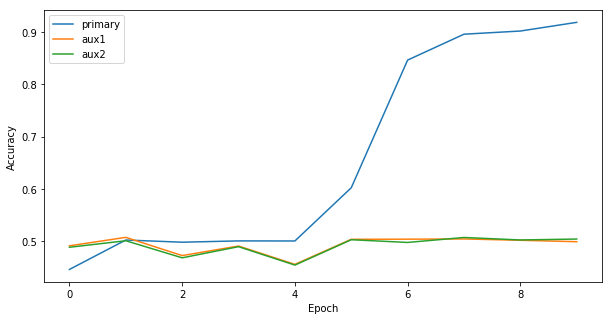

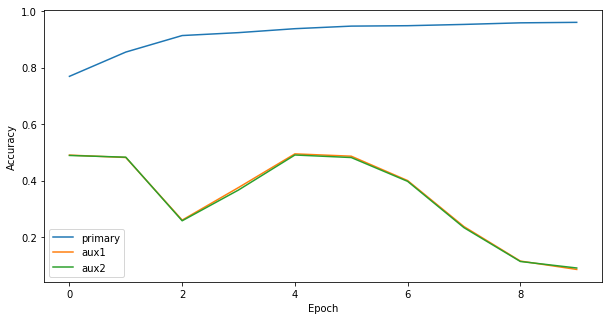

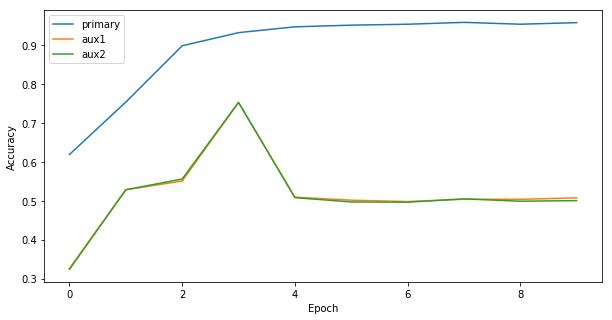

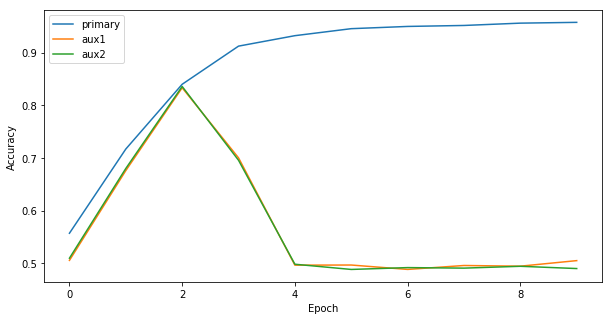

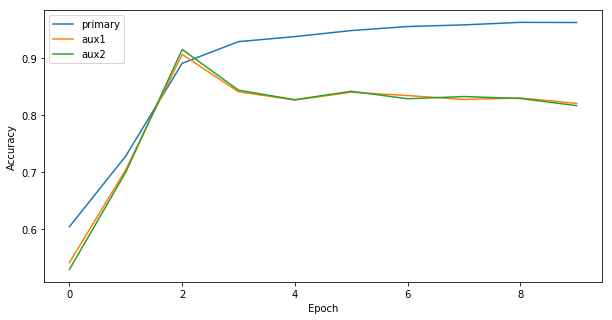

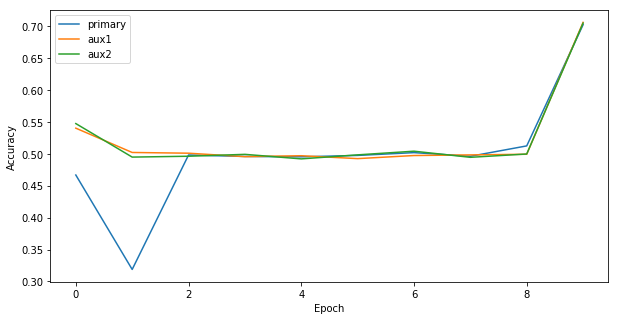

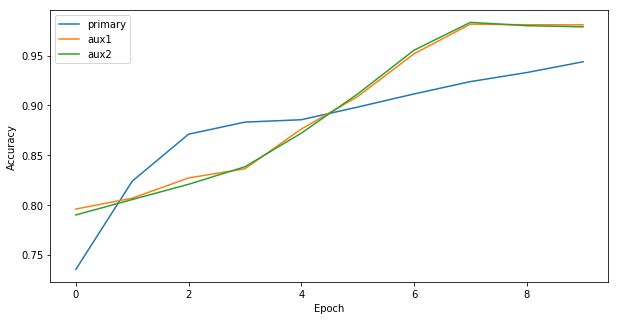

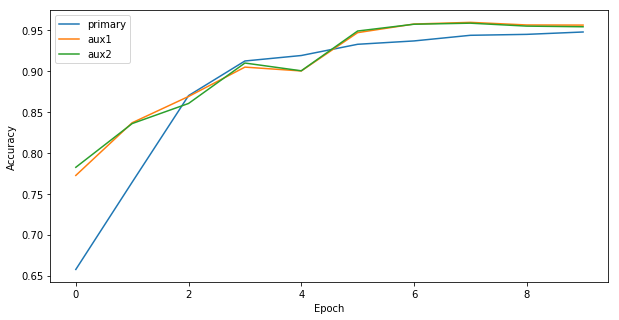

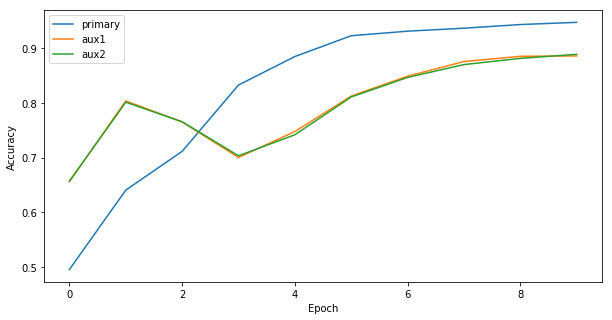

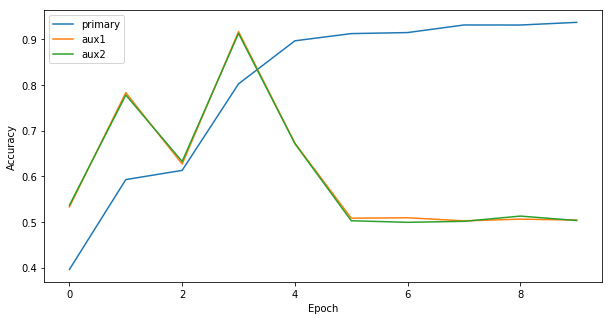

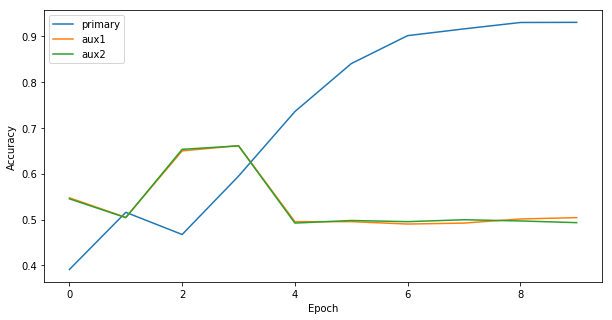

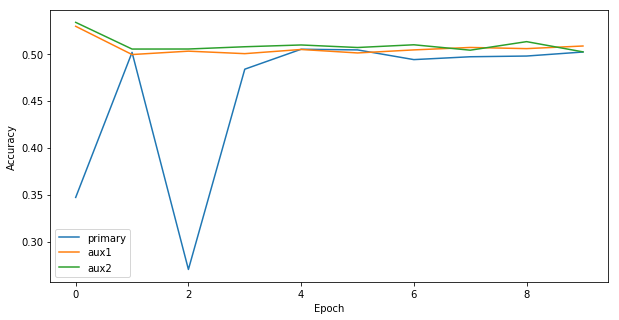

In [30]:
# Plot loss trajectory throughout training.
for i in range(graphs):
    plt.figure(i+1, figsize=(10,5))
    plt.plot(history[i].history['out_acc'], label='primary')
    plt.plot(history[i].history['aux1_acc'], label='aux1')
    plt.plot(history[i].history['aux2_acc'], label='aux2')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
#fig = plt.figure()
#fig.subplots_adjust(hspace=0.4, wspace=0.4)
#for i in range(1, 7):
#    ax = fig.add_subplot(2, 3, i)
#    ax.text(0.5, 0.5, str((2, 3, i)),
#           fontsize=18, ha='center')